# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: spherical harmonics vs graph Fourier modes

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import os
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
import pygsp as pg
import itertools

from deepsphere import utils

In [40]:
plt.rcParams['figure.figsize'] = (17, 5)  # (9, 4) for matplotlib notebook

nside = 16
cm = plt.cm.RdBu_r
cm.set_under('w')

## 1 Spherical harmonics

* Spherical harmonics are indexed by degree (or angular frequency) $\ell$ and order $m \in [0, \ell]$.
* $l=0$ is the constant, $l=1$ is the two monopoles, $l=2$ is the three dipoles, etc.
* Coefficients are commonly defined as $a_{\ell m}$.
* A spherical harmonic takes value $Y_\ell^m(\theta, \phi)$ in angular direction $(\theta, \phi)$.
* In HEALPix, as we only deal with maps of real numbers, the representation is complex and the relation $a_{\ell, m}^* = a_{\ell, -m}$ holds. As such, to generate all $2\ell + 1$ orders, one needs to e.g. transform $a_{\ell m} = 1 + 1j$ and $a_{\ell m} = 1 - 1j$.

6 spherical harmonics for l in [0, 2]
l=2, m=0 is at index 2


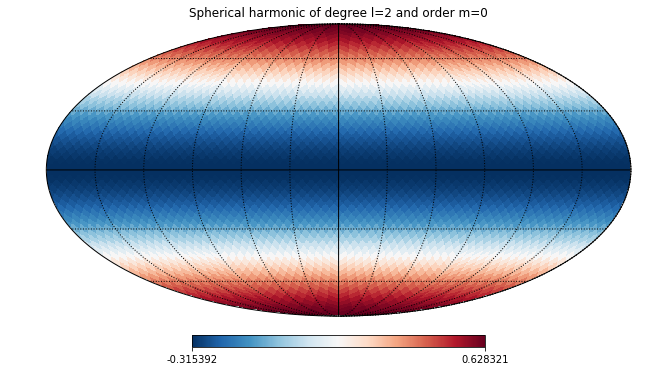

In [41]:
def plot_spherical_harmonic(nside, l, m):

    lmax = l
    idx = hp.sphtfunc.Alm.getidx(lmax, l, m)
    size = hp.sphtfunc.Alm.getsize(lmax, mmax=lmax)
    print('{} spherical harmonics for l in [0, {}]'.format(size, lmax))
    print('l={}, m={} is at index {}'.format(l, m, idx))

    alm = np.zeros(size, dtype=np.complex128)
    alm[idx] = 1

    map = hp.sphtfunc.alm2map(alm, nside, lmax, verbose=False)
    hp.mollview(map, title="Spherical harmonic of degree l={} and order m={}".format(l,m), cmap=cm)
    #hp.cartview(map, title=f"Spherical harmonic l={l}, m={m}")
    with utils.HiddenPrints():
        hp.graticule();
plot_spherical_harmonic(nside, l=2, m=0)

Compute the spherical harmonics up to $\ell_{max}$ and plot them.

In [42]:
harmonics = utils.compute_spherical_harmonics(nside, lmax=18)
harmonics.shape

(3072, 361)

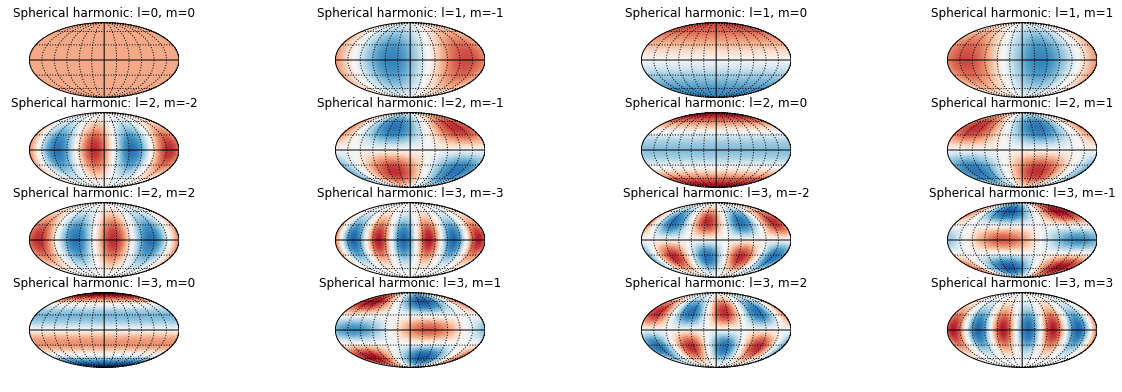

In [43]:
def plot_harmonics(harmonics, title=''):
    n_harmonics = harmonics.shape[1]
    l, m = 0, 0
    for idx in range(n_harmonics):
        hp.mollview(harmonics[:, idx], 
                    title='{}: l={}, m={}'.format(title, l, m),
                    nest=True,
                    sub=(np.sqrt(n_harmonics), np.sqrt(n_harmonics), idx+1),
                    max=np.max(np.abs(harmonics)),
                    min=-np.max(np.abs(harmonics)),
                    cbar=False,
                    cmap=cm)
        
        m += 1
        if m > l:
            l += 1
            m = -l
    with utils.HiddenPrints():
        hp.graticule();
plot_harmonics(harmonics[:, :16], 'Spherical harmonic')

## 2 Graph Fourier modes

The graph Fourier modes are the eigenvectors of the graph Laplacian.
$$L = U \Lambda U^T$$

In [44]:
graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)
graph.compute_fourier_basis()

2019-03-19 09:28:56,604:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (3072 x 3072) is expensive. Consider decreasing n_eigenvectors or, if using the Fourier basis to filter, using a polynomial filter instead.


The weighted adjacency matrix is very sparse. Distance between pixels is not constant.

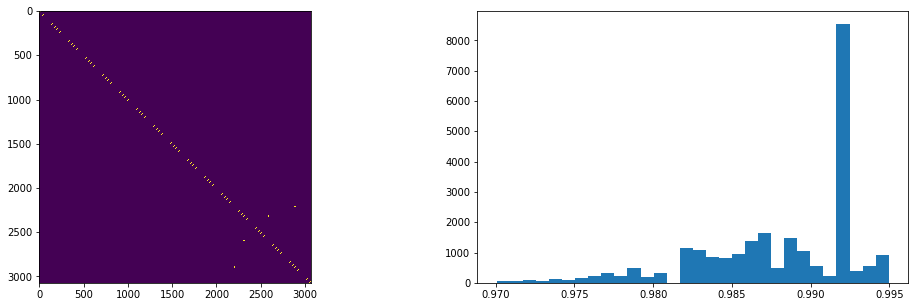

In [45]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(graph.W.toarray())
axes[1].hist(graph.W[graph.W>0].T,30);

Fourier modes of the graph.

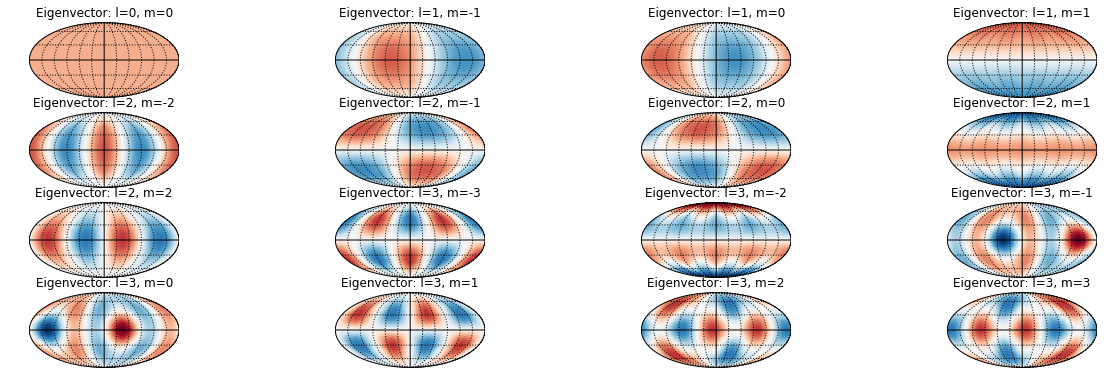

In [46]:
plot_harmonics(graph.U[:, :16], 'Eigenvector')

The eigenvalues are clearly organized in groups, which corresponds to angular frequencies $\ell$ of the spherical harmonics.

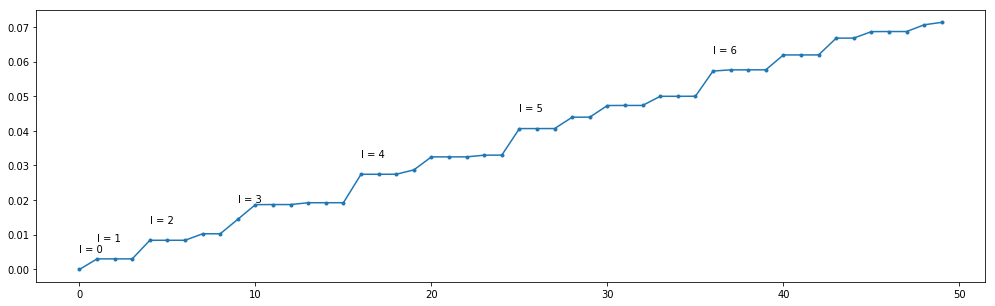

In [47]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

The Fourier modes capture the spherical geometry.

The eigenvectors can be used to embed any graph in a 3D space.
In our case, that should produce a sphere.
That is [Laplacian eigenmaps](http://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf), an algorithm that preserves local distances.

Question: are the graph representation and the embedding actually equivalent?

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(graph.U[:, 1], graph.U[:, 2], graph.U[:, 3], c=graph.d);

# The spherical harmonics obviously capture the geometry too.
# ax.scatter(harmonics[:, 1], harmonics[:, 2], harmonics[:, 3], c=graph.d);

## 3 Spherical harmonics on the graph

Todo:
* Smoothness of rotated spherical harmonics should be constant.

In [ ]:
# Combinatorial Laplacian for the spherical harmonics.
graph = utils.healpix_graph(nside, lap_type='combinatorial', nest=True, dtype=np.float64)
graph.compute_fourier_basis()

Let us try to re-order the spherical harmonic with respect of the graph frequencies

In [ ]:
ind = np.argsort(np.diag(harmonics.T @ graph.L @ harmonics))
harmonics_sort = harmonics[:,ind]

Spherical harmonics are not exactly orthogonal on the graph.

In [ ]:
C_euclidean = harmonics_sort.T @ harmonics_sort
C_graph = (harmonics_sort.T @ graph.L @ harmonics_sort) #@ np.diag(1/(graph.e[:harmonics_sort.shape[1]] +0.0001))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(C_euclidean)
axes[1].imshow(C_graph)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.diag(C_euclidean))
axes[1].plot(np.diag(C_graph), label='diag(F^T L F)')
axes[1].plot(graph.e[:harmonics_sort.shape[1]],label='graph eigenvalues')
axes[1].legend()

## 4 Correspondance of the subspaces

* Are the subspaces equivalent?
* Is the projection on the subspaces similar?
* TODO: what is `win = hp.sphtfunc.pixwin(nside=32)`?

### 4.1 Graph eigenvectors vs sampled spherical harmonics

That is not an exact representation of the correspondance as in the case of non-uniform sampling, the integrals (i.e., the SHT) are not equal to the dot products with the sampled harmonic functions (which aren't orthogonal and hence don't form a basis).

In [ ]:
lmax = 10
n_harmonics = np.sum(np.arange(1, 2*lmax+2, 2))
print('{} harmonics for lmax = {}'.format(n_harmonics, lmax))

In [ ]:
C = harmonics[:, :n_harmonics].T @ harmonics[:, :n_harmonics]
print(np.linalg.norm(C, ord='fro'))

C = graph.U[:, :n_harmonics].T @ graph.U[:, :n_harmonics]
print(np.linalg.norm(C, ord='fro'))

C = harmonics[:, :n_harmonics].T @ graph.U[:, :n_harmonics]
print(np.linalg.norm(C, ord='fro'))

plt.imshow(np.abs(C), cmap=plt.cm.gist_heat_r)
plt.colorbar()

### 4.2 The sampled spherical harmonics don't form an orthonormal basis

* The spherical harmonics are not exactly orthonormal (they don't form a basis).
* They're not orthonormal as they are a sampling of the true eigenfunctions.
* If the sampling is not uniform, the dot product is not equal to the integral.

In [ ]:
def show_non_orthogonality(nside, lmax):

    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)
    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics[-1])

    C = harmonics.T @ harmonics
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(np.sum(C**2, axis=1))
    axes[0].plot(C.diagonal())

    # Hence the rows and columns of the correlation matrix don't sum up to one.
    C = harmonics.T @ graph.U[:, :harmonics.shape[1]]
    axes[1].plot(np.sum(C**2, axis=0))
    axes[1].plot(np.sum(C**2, axis=1));

show_non_orthogonality(nside=16, lmax=8)

### 4.3 Percentage of energy in the corresponding subspaces

TODO: the graph should be constructed (if that's even possible) such that the Fourier modes converge to the spherical harmonics while we sample more (i.e., nside increases).

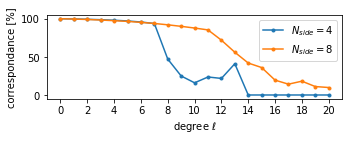

In [66]:
lmax = 20
nsides = [4, 8]

# Normalized corresponds better than combinatorial. Less difference between nsides.
# lap_type='combinatorial'
lap_type='normalized'

def compute_orhtogonality(nside, lmax, lap_type='normalized'):
    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))

    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)

    graph = utils.healpix_graph(nside, lap_type=lap_type, nest=True, dtype=np.float64)
    n_eigenvectors = min(n_harmonics[-1], graph.N)
    graph.compute_fourier_basis(n_eigenvectors)

    C = harmonics.T @ graph.U
    
    return C, n_harmonics

def compute_energy(C, lmax):
    """Compute the percentage energy in each subspace (diagonal blocks)."""
    energy_in = np.empty(lmax+1)
    start = 0
    for ell in range(lmax + 1):
        n_harmonics = 2*ell + 1
        end = start + n_harmonics
        energy_square = np.sum(C[start:end, start:end]**2)
        # col_sum = np.sum(C[start:end, :]**2)  # how each harmonic are distributed on all eigenvectors
        # row_sum = np.sum(C[:, start:end]**2)  # how each eigenvector are distributed on all harmonics
        # np.testing.assert_allclose(col_sum, n_harmonics, rtol=1e-2)
        # np.testing.assert_allclose(row_sum, n_harmonics, rtol=1e-2)
        energy_in[ell] = energy_square / n_harmonics
        start = end
    return energy_in

energy = dict()

for nside in nsides:
    C, _ = compute_orhtogonality(nside, lmax, lap_type)
    energy[nside] = compute_energy(C, lmax)

fig, ax = plt.subplots(figsize=(5, 2))
for nside in nsides:
    ax.plot(range(lmax+1), 100*energy[nside], '.-', label=rf'$N_{{side}}={nside}$')
ax.legend()
ax.set_ylabel('correspondance [%]')
ax.set_xlabel('degree $\ell$')
ax.set_xticks(range(0, lmax + 1, lmax//10))
fig.tight_layout();
# fig.savefig(os.path.join(pathfig, 'subspace_alignment.pdf'))

### 4.4 approximate SHT with a NUDFT (anafast) of the graph eigenvectors

That is a better way to compare, as it uses the real spherical harmonic transform (SHT).

### ANAFAST: what is it?
Execution of anafast requires a user to specify the maximum spherical harmonic order  $\ell_{\mathrm{max}}$ up to which the harmonic decomposition of the input maps will be performed. Since there are no formal limits on parameter  $\ell_{\mathrm{max}}$ enforced by anafast, the user should make his/her choices judiciously. Hereafter it is convenient to specify  $\ell_{\mathrm{max}}$ in terms of the HEALPix map resolution parameter Nside (called nsmax in some other contexts). 

If the function to be analysed is strictly band-width limited, or nearly band-width limited (as in the case of a Gaussian beam smoothed signal discretized at a rate of a few pixels per beam area), it is sufficient to run anafast with  $\ell_{\mathrm{max}}\approx 2\cdot N_{\mathrm{side}}$, with a very good $C_\ell$ error performance already in the raw (i.e. uncorrected quadrature) harmonic transform mode. If quadrature corrections are still desired in this case, it should be sufficient to use, at no extra cost in execution time, the ring-weighted quadrature scheme. This is the recommended mode of operation of anafast for essentially error and worry free typical applications, e.g. CPU-intensive Monte Carlo studies. 

A new set of pixel-based quadrature weights was introduced in HEALPix 3.40. Pre-computed to inforce a (near) ideal integration of the spherical harmonics $Y_{\ell m}$ on the pixelized sphere (ie  $\frac{4\pi}{N_{\mathrm{pix}}} \sum_p w(p) Y_{\ell m}(p) = \sqrt{4 \pi} \delta_{\ell 0}\delta_{m 0}$) for  $\vert m\vert \le \ell \le 3 N_{\mathrm{side}}$, they can be used to insure that the $a_{\ell m}$ and $C_\ell$ computed by anafast are perfectly accurate (almost to machine precision) without the need for iterations, but only for band-width limited input signal with  $\ell_{\mathrm{max}}\le 1.5 N_{\mathrm{side}}$. 

If more aggressive attempts are undertaken to extract from a map the spectral coefficients at  $\ell > 2\cdot N_{\mathrm{side}}$ (for example, as in a possible case of an attempt to analyse an existing map, which was irreversibly binned at a suboptimal resolution) the following should be kept in mind: 

$\bullet$ __Spherical harmonics discretized using HEALPix (either sampled at pixel centers, or avaraged over pixel areas) form a linearly independent system up to  $\ell_{\mathrm{max}}= 3 \cdot N_{\mathrm{side}}-1$. Hence, the functions which are strictly band-width limited to  $\ell_{\mathrm{max}}= 3 \cdot N_{\mathrm{side}}-1$ can be fully spectrally resolved with anafast, albeit with integration errors in the uncorrected quadrature mode__, which grow up to  $\delta C_\ell \propto \epsilon \cdot C_\ell$, with $\epsilon <0.1$, at the highest values of $\ell$. These integration errors can be efficiently reduced using anafast in the iterative mode. Although this  $\ell_{\mathrm{max}}$ range --  $2 \cdot N_{\mathrm{side}}< \ell_{\mathrm{max}}< 3 \cdot N_{\mathrm{side}}- 1$ -- is easily manageable with anafast used on strictly band-width limited functions, it should be used with caution in basic and automated applications, e.g. Monte Carlo simulations. 

$\bullet$ __As with any discrete Fourier transform, anafast application to functions which are not band-width limited results with aliasing of power, which can not be remedied__. If the particular case of interest may result in such a band-width violation (i.e. there is significant power in the function at  $\ell > 3 \cdot N_{\mathrm{side}}-1$), the function should be smoothed before the application of anafast, or discretized and then analysed, on a refined HEALPix grid (with larger Nside). 

$\bullet$ REMEMBER: A peculiar property of the sphere, which usually surprises those whose intuition is built on experience with FFTs on a segment, or on a Euclidean
multidimensional domain, is the lack of a regular and uniform point-set at arbitrary resolution, and the resulting __non-commutativity of the forward and backward discrete Fourier transforms__ on nearly-uniform point-sets, e.g. HEALPix. Hence, as in any case of attempting an extreme application of an off-the-shelf software, use caution and understand your problem well before executing anafast under such circumstances!


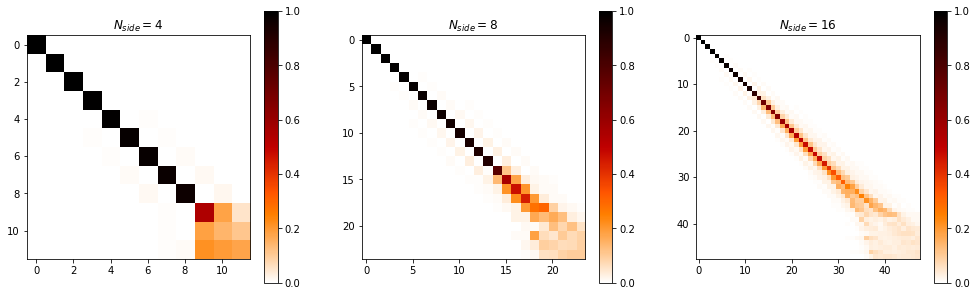

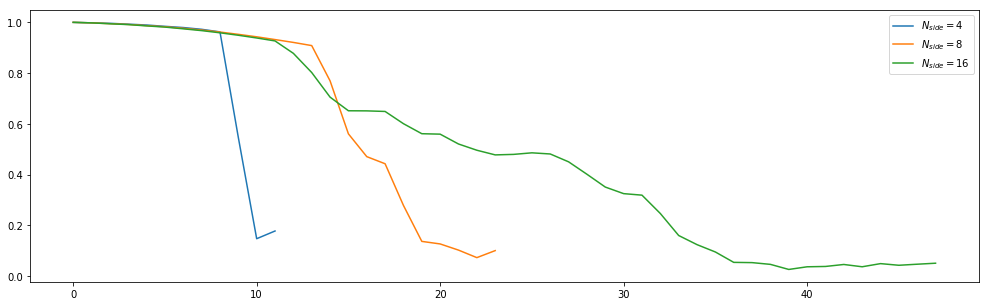

In [57]:
# nsides = [4, 8, 16, 32]  # slow
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1  # default in healpy.anafast

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64, std_dev='kernel_width')
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

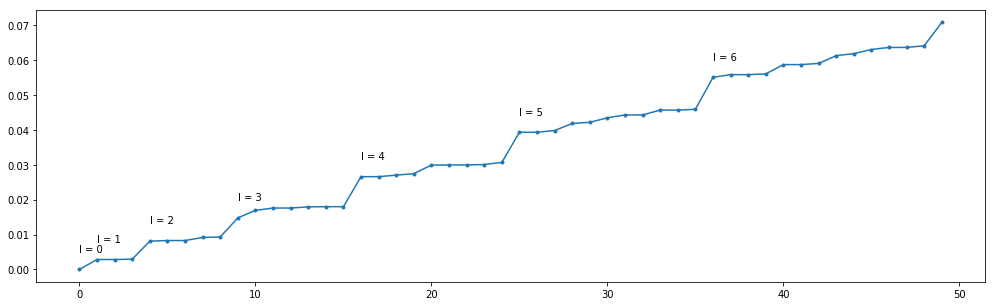

In [59]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### 4.5 Testing convergence of Belkin & Nyiogi setting
More or less: here the sampling is deterministic (HEALPix) but we construct a full graph

I added two functions to deepsphere.utils: __full_healpix_graph__ and __full_healpix_weightmatrix__.
__full_healpix_weightmatrix__() uses as standard deviation of the gaussin kernel exactly the formula used in Belkin&Nyiogi, and NOT the mean of the distances.

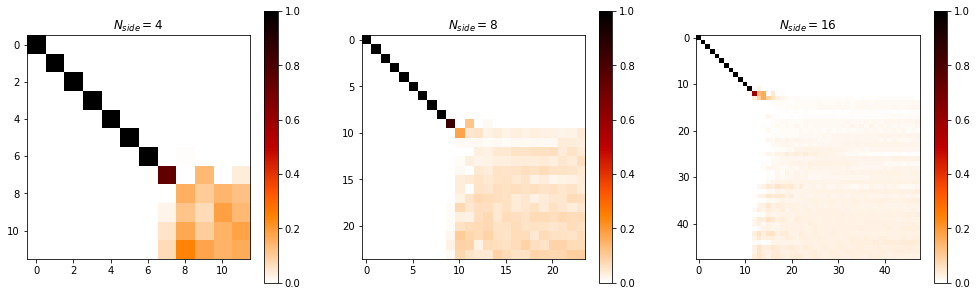

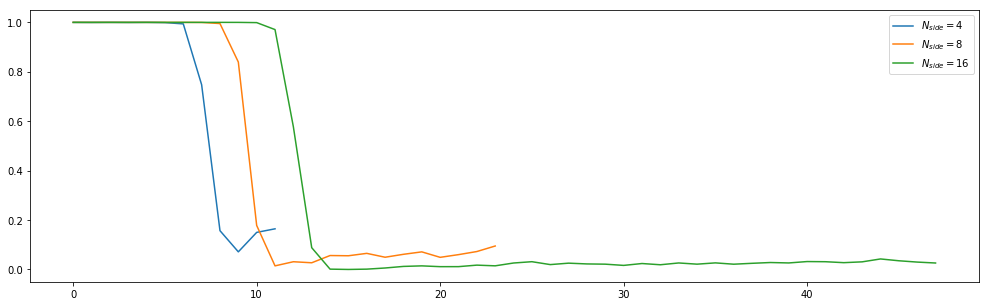

In [60]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std="BelkinNyiogi")  # in NEST order
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

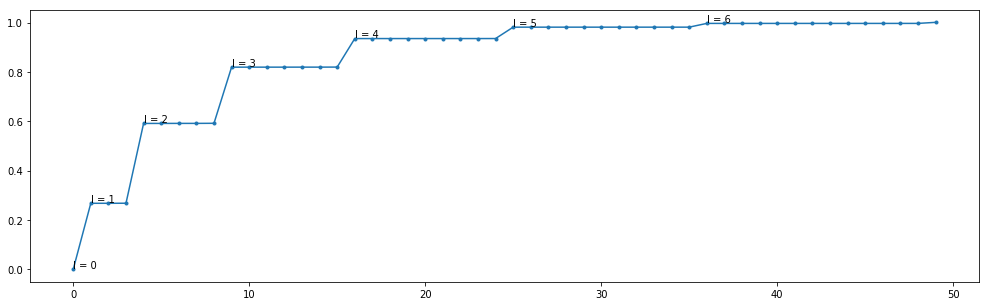

In [61]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### 4.6 Now we try with a FULL graph with a standard deviation set to mean distance of the dataset
This is to see if the convergence is due to the standard deviation or to the density pattern (or both)

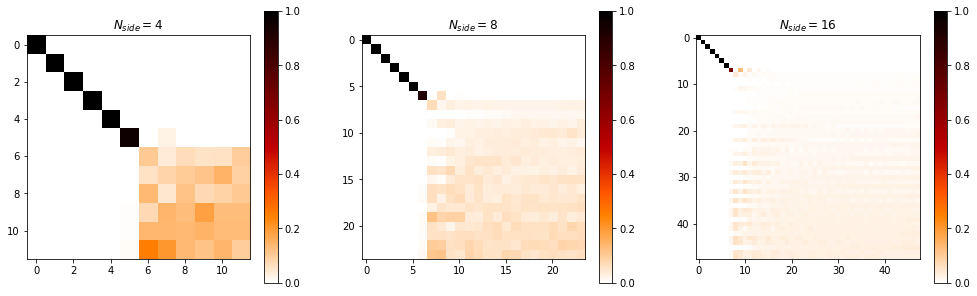

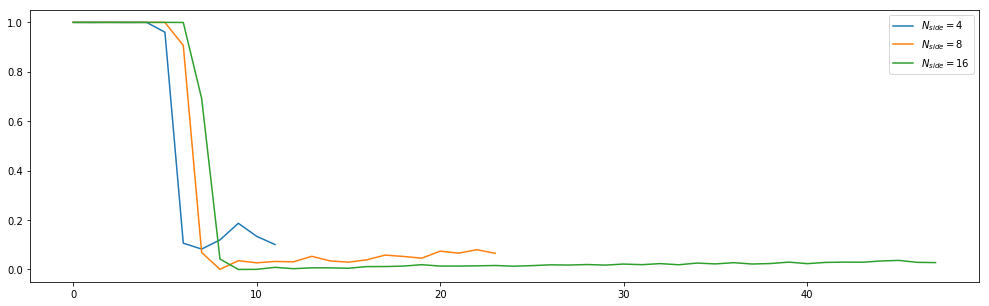

In [62]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std="kernel_width")  # in NEST order
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

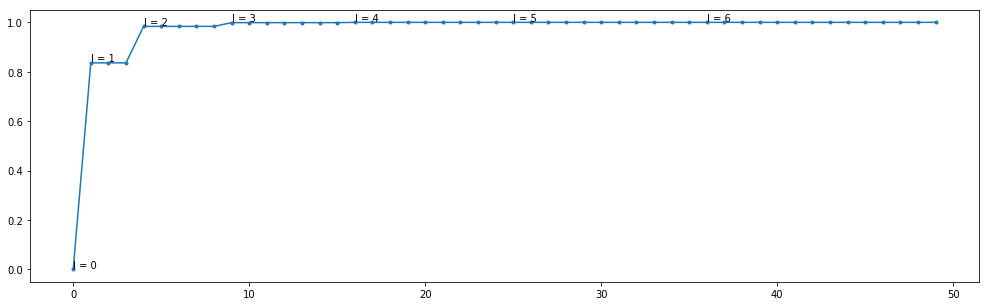

In [63]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

It seems that the convergence is still there, but now it is way slower! Now the question is: what is provoking this convergence? a Shannon theorem (perfect reconstruction up to a certain bandwidth) or is it just an asymptotic thing (Belking/Nyiogi style)? The superfast decay of the plot indicating the energy on the diagonal indicate that the graph fourier eigenvectors approximate the real sphericl harmonics almost exactly for a while, and then boom something wrong happens.

Now that we saw that the std dev is really important, let's see what happens to the sparse graph (7/8 neighbors) and the Belkin & Nyiogi std. dev.!

### 4.7 Sparse graph with Belkin-Nyiogi standard deviation

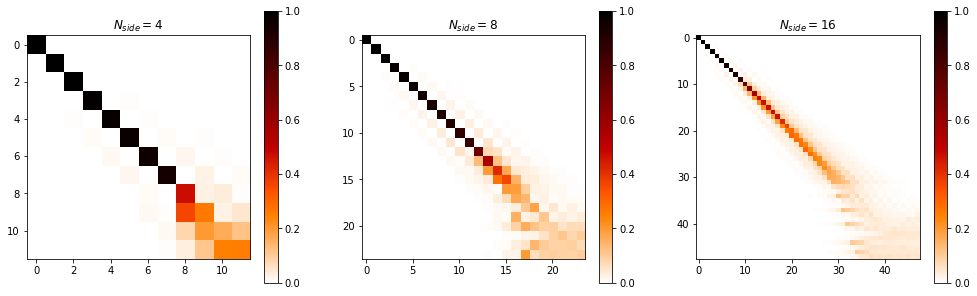

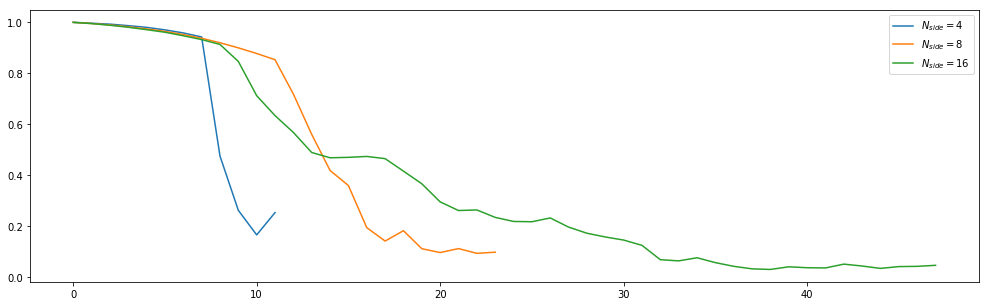

In [64]:
# nsides = [4, 8, 16, 32]  # slow
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64, std_dev='BelkinNyiogi')
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

__In this case (sparse graph) the standard deviation does not seem to help at all!__

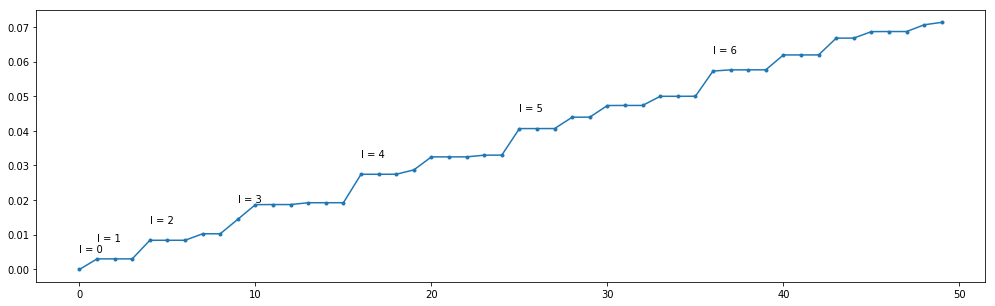

In [65]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### 4.7 Just for confirmation: SHT of the sampled spherical harmonics

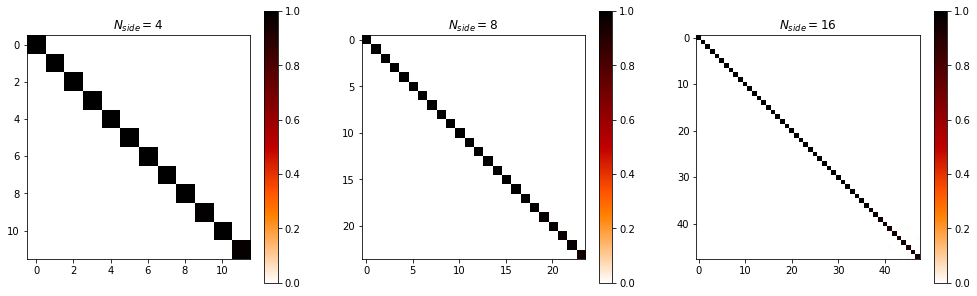

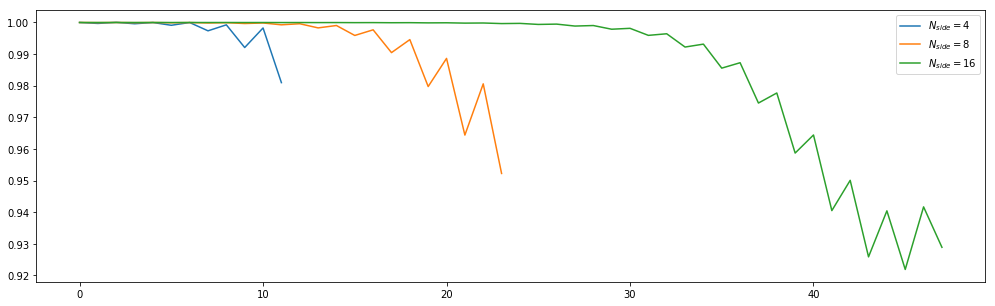

In [30]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1
    
    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)
    n_harmonics = harmonics.shape[1]
    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        harmonic = hp.reorder(harmonics[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(harmonic, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();


## 5 Action of the graph Laplacian

We don't care if the Fourier modes are not exactly the spherical harmonics, but we want the Laplacian operator to be close.

The Laplacian is a second order operator on the sphere (see [Laplace's spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics#Laplace's_spherical_harmonics)):

$$
r^2 \nabla^2 Y_\ell^m(\theta, \phi) = -\ell (\ell + 1) Y_\ell^m(\theta, \phi).
$$

Pluging in the graph Laplacian $L = -\nabla^2$ and setting the radius $r=1$ gives

$$
L Y_\ell^m(\theta, \phi) = \ell (\ell + 1) Y_\ell^m(\theta, \phi)
\\
L a_\ell^m = \ell (\ell + 1) a_\ell^m
$$

So multiplying a map with the Laplacian $L$ should affect its spectrum in a predictable way.

TODO:
* a normalization factor might be missing in the Laplacian
* ripple in the error at low-frequency
    * Laplacian is approximated by finite differences => greater disc
    * influence of Nside?
    * due to adjacency being too local? More than 8 neighbors. Get coords of pixels with `hp.pixelfunc.pix2ang` or `hp.query_disc`.
    * construct with angular distance
    * alternative: check that it gets worse with less neighbors.
* average across many realizations

In [ ]:
folder = 'data'
name = 'COM_CMB_IQU-smica_1024_R2.02_full.fits'
if not os.path.exists(os.path.join(folder, name)):
    url = 'https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/cmb/' + name
    utils.download(url, folder, name)

In [ ]:
nside = 32
npix = 12 * nside**2  # hp.nside2npix
print('Nside = {}, Npix = {}'.format(nside, npix))

graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)

if True:
    map1_n, _, _ = hp.read_map('data/COM_CMB_IQU-smica_1024_R2.02_full.fits', field=(0, 1, 3), nest=True)
    map1_n = hp.ud_grade(map1_n, nside_out=nside, order_in='NESTED')
else:
    map1_n = np.random.normal(size=hp.nside2npix(nside))
    # map1_n -= map1_n.mean()

map1_r = hp.reorder(map1_n, n2r=True)

hp.mollview(map1_r)

cl1 = hp.sphtfunc.anafast(map1_r)
fig, ax = plt.subplots()
ax.plot(cl1);

Ratio between the SHT of the map before and after multiplication by the Laplacian. The frequency response should be equal to $\ell (\ell + 1)$.

In [ ]:
map2_n = graph.L @ map1_n

map2_r = hp.reorder(map2_n, n2r=True)

cl2 = hp.sphtfunc.anafast(map2_r)
cl12 = hp.sphtfunc.anafast(map1_r, map2_r)

ratio1 = cl2 / cl1
plt.plot(ratio1, label='Empirical response')

ratio2 = cl12 / cl1
plt.plot(ratio2, label='Empirical response')
#plt.plot(ratio[2:])
#plt.plot(area * ratio)

# The scaling issue (the asymptotic value of the error) is probably related to the area of the pixels.
area = 4*np.pi / npix
print('Area of a pixel: {:.2e}'.format(area))

l = np.arange(cl1.shape[0])
ideal = l*(l+1) * area / 4
plt.plot(l, ideal, label='Ideal response: $\ell(\ell+1)$')

plt.legend();

In [ ]:
plt.plot(cl2);
plt.plot(cl12);

In [ ]:
error = ratio1 / ideal
plt.semilogy(error);

error = ratio2 / ideal
plt.semilogy(error);

## 6 Action of graph filters

We don't care if the Fourier modes are not exactly the spherical harmonics, but we want the Laplacian operator to be close. Or, at least, the filtering operations to be close.

Todo:
* Measure mean and variance of the difference between a graph filter and the ideal SHT filter at all locations.

Functions:
* `healpy.sphtfunc.map2alm` => spherical harmonic transform (SHT)
* `healpy.sphtfunc.almxfl` => arbitrary smoothing
* `healpy.sphtfunc.smoothing` => Gaussian smoothing

In [ ]:
nside = 256

map, _, _ = hp.read_map('data/COM_CMB_IQU-smica_1024_R2.02_full.fits', field=(0, 1, 3), nest=True)
map = hp.ud_grade(map, nside_out=nside, order_in='NESTED')
map = hp.reorder(map, inp='NESTED', out='RING')
# map = np.random.normal(size=hp.nside2npix(nside))

lmax = 3 * nside - 1

print("We'll compute {} frequencies".format(lmax))
hp.mollview(map)

In [ ]:
alm = hp.sphtfunc.map2alm(map)
plt.plot(np.abs(alm))

l, m = hp.Alm.getlm(lmax=lmax)
print(list(zip(l, m))[:100])

In [ ]:
cl = hp.sphtfunc.anafast(map)
plt.plot(cl)

In [ ]:
graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)
map = graph.L @ map

In [ ]:
alm = hp.sphtfunc.map2alm(map)
plt.plot(np.abs(alm))

In [ ]:
cl = hp.sphtfunc.anafast(map)
plt.plot(cl)

Discrete low-pass filtering using the graph eigenvectors and the spherical harmonics.
Note that taking the dot product between the sampled spherical harmonics and the map to filter is not equivalent to performing the filtering with the real SHT.

In [ ]:
def compare_filtering(nside=16, n_signals=100):
    n_harmonics = 16
    n_pixels = harmonics.shape[0]

    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    signals = np.random.uniform(size=(n_pixels, n_signals))
    eigenvectors = graph.U
    harmonics_ = harmonics[:, :n_harmonics]

    signals_sphere = harmonics_ @ harmonics_.T @ signals
    signals_graph = eigenvectors @ eigenvectors.T @ signals

    hp.mollview(signals[:, 0], nest=True)
    hp.mollview(signals_sphere[:, 0], nest=True)
    hp.mollview(signals_graph[:, 0], nest=True)

    error = signals_graph - signals_sphere
    hp.mollview(error[:, 0], nest=True)
    print(np.linalg.norm(error, ord='fro'))

compare_filtering()

## 7 Spherical power spectrum

The angular power spectrum is given by
$$ \hat{C}_\ell = \frac{1}{2\ell + 1} \sum_m |\hat{a}_{\ell m}|^2 $$
As such, $\hat{C}_\ell$ is the expected variance of the $\hat{a}_{\ell m}$ at order $\ell$.
It also implies the standard result that the total power at the angular wavenumber $\ell$ is $(2\ell + 1) \hat{C}_\ell$ because there are $2\ell + 1$ modes for each $\ell$.

Todo:
* speed
* accuracy

In [ ]:
psd = hp.sphtfunc.anafast(map, lmax=lmax)
plt.semilogy(psd);

## 8 Filtering speed

TODO:
* filtering with tensorflow / numpy / pytorch
* Similarly for a part of the sphere
* speed and accuracy w.r.t. polynomial order

Functions:
* `healpy.sphtfunc.almxfl` => arbitrary smoothing
* `healpy.sphtfunc.smoothing` => Gaussian smoothing

In [ ]:
nside = 256

map, _, _ = hp.read_map('data/COM_CMB_IQU-smica_1024_R2.02_full.fits', field=(0, 1, 3), nest=True)
map = hp.ud_grade(map, nside_out=nside, order_in='NESTED')
map = hp.reorder(map, inp='NESTED', out='RING')

hp.mollview(map)

Smoothing by filtering with spherical harmonics, i.e., do an element-wise multiplication in the spectral domain after a spherical transform.

In [ ]:
smooth = hp.sphtfunc.smoothing(map, sigma=0.01, verbose=False)
hp.mollview(smooth)

Smoothing by filtering on graphs.

In [ ]:
graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)
graph.estimate_lmax()

map = hp.reorder(map, inp='RING', out='NESTED')

filter = pg.filters.Heat(graph, tau=30)
filter = filter.approximate('Chebyshev', order=10)
filter.plot()

smooth = filter.filter(map)
hp.mollview(smooth, nest=True)

Compare the speed of both approaches.

We limit OpenMP (used by HEALPix) to use a single core as graph convolutions are not parallelized yet. While the mutliplication of sparse matrices with dense vectors can be parallelized, it is not implemented by scipy. It's hopefully implemented in tensorflow or pytorch.

In [ ]:
nsides = [64, 128, 256, 512, 1024, 2048]  # Max 1024 for the real Planck map.

# Polynomial orders for graph filtering.
orders = [5, 15]

# Largest order (angular frequency) for the spherical harmonic transform.
# lmax = lmax * nsides. HEALPix default is 3*nside-1.
lmax = [2, 3]

# Number of OpenMP threads for spherical harmonics.
os.environ['OMP_NUM_THREADS'] = '1'

times_graph = np.zeros((len(nsides), len(orders)))
times_sphere = np.zeros((len(nsides), len(lmax)))

for i, nside in enumerate(nsides):

    # map = hp.ud_grade(map_cmb, nside_out=nside, order_in='NESTED')
    map = np.random.normal(size=hp.nside2npix(nside))

    # Filtering on the graph. Need the nested ordering.
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)
    graph.estimate_lmax()
    for j, order in enumerate(orders):
        filter = pg.filters.Heat(graph, tau=30).approximate('Chebyshev', order=order)
        t = time()
        smooth = filter.filter(map)
        times_graph[i, j] = time() - t

    # Filtering with the spherical harmonics. Need the ring ordering.
    map = hp.reorder(map, inp='NESTED', out='RING')
    for j, lm in enumerate(lmax):
        t = time()
        hp.sphtfunc.smoothing(map, sigma=0.01, verbose=False, lmax=lm*nside)
        times_sphere[i, j] = time() - t

# Reset OpenMP to use all available cores.
del os.environ['OMP_NUM_THREADS']

In [ ]:
# Save results for the plot in the paper.
np.savez('results/filtering_speed.npz', nsides=nsides, orders=orders,
         lmax=lmax, times_sphere=times_sphere, times_graph=times_graph)

In [ ]:
fig, ax = plt.subplots()
npix = [hp.nside2npix(nside) for nside in nsides]
ax.loglog(npix, times_graph, '.-')
ax.loglog(npix, times_sphere, ':')
labels = ['Graph, polynomial order {}'.format(order) for order in orders]
labels += ['Spherical harmonics, $\ell_{{max}}$ = {}$N_{{side}}$'.format(lm) for lm in lmax]
ax.legend(labels)
for i, nside in enumerate(nsides):
    ax.text(npix[i], times_sphere[i, -1] * 1.8, 'Nside = {}'.format(nside), horizontalalignment='center')
ax.set_ylim(0.8 * times_graph.min(), 3 * times_sphere.max())
ax.set_xlabel('Number of pixels')
ax.set_ylabel('Processing time [s]')
ax.set_title('Single core performance');
#ax.ticklabel_format(style='sci', axis='x')

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(orders, times_graph.T, '.-')
labels = ['Filtering with graphs, Nside = {}'.format(nside) for nside in nsides]
ax.legend(labels)
ax.set_xlabel('Polynomial order')
ax.set_xticks(orders)
ax.set_ylabel('Processing time [s]');

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(lmax, times_sphere.T, '.-')
labels = ['Filtering with spherical harmonics, Nside = {}'.format(nside) for nside in nsides]
ax.legend(labels)
ax.set_xlabel('lmax')
ax.set_xticks(lmax)
ax.set_ylabel('Processing time [s]');

## 9 Convergence when number of pixels goes to infinity

As a graph representation of the sphere is not dependant on the sampling, we can compute spherical harmonics from random samplings of the sphere. As the sampling increases, the eigenvectors approach the spherical harmonics.

Do the eigenvalues converge to the orders $\ell$, i.e. do the stairs become flatter, when increasing $N_{pix}$? No, they mostly stay the same.

In [ ]:
n_points = [100, 500, 1000]
#fig, axes = plt.subplots(1, len(n_points))

for i, n_points in enumerate(n_points):
    graph = pg.graphs.Sphere(nb_pts=n_points)
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)
    graph.plot_signal(graph.U[:, 1], edges=False)#, ax=axes[0])
    plt.axis('off')

## 9 Part of sphere

Tweak the part graph such that the eigenvectors computed on parts of the sphere are as if we would have restricted the global eigenvectors to a part of sphere.

Todo: Mais tu peux essayer sur une grille normale. Le plus simple pour vérifier si c'est possible, c'est de vérifier s'il est nécessaire d'avoir une matrice circulante pour avoir des exponentielles complexes comme vecteurs propres.